In [1]:
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
import numpy as np 
import matplotlib.pyplot as plt
import os
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
pd.set_option('display.max_colwidth', None)

input_path = '../input' # path to the input data

2022-11-20 14:00:36.906681: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-20 14:00:37.152770: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-20 14:00:37.152908: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-20 14:00:37.187534: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-20 14:00:38.270240: W tensorflow/stream_executor/platform/de

# Data Quality Assesment

In [2]:
dataset = pd.read_json(f'{input_path}/news-category-dataset/News_Category_Dataset_v3.json', lines=True)
dataset.drop(['authors', 'link', 'date'], axis = 1, inplace = True) 
dataset.head()

,headline,category,short_description
0,Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters,U.S. NEWS,Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.
1,"American Airlines Flyer Charged, Banned For Life After Punching Flight Attendant On Video",U.S. NEWS,"He was subdued by passengers and crew when he fled to the back of the aircraft after the confrontation, according to the U.S. attorney's office in Los Angeles."
2,23 Of The Funniest Tweets About Cats And Dogs This Week (Sept. 17-23),COMEDY,"""Until you have a dog you don't understand what could be eaten."""
3,The Funniest Tweets From Parents This Week (Sept. 17-23),PARENTING,"""Accidentally put grown-up toothpaste on my toddler’s toothbrush and he screamed like I was cleaning his teeth with a Carolina Reaper dipped in Tabasco sauce."""
4,Woman Who Called Cops On Black Bird-Watcher Loses Lawsuit Against Ex-Employer,U.S. NEWS,Amy Cooper accused investment firm Franklin Templeton of unfairly firing her and branding her a racist after video of the Central Park encounter went viral.


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   headline           209527 non-null  object
 1   category           209527 non-null  object
 2   short_description  209527 non-null  object
dtypes: object(3)
memory usage: 4.8+ MB


In [4]:
dataset.describe()

,headline,category,short_description
count,209527,209527,209527
unique,207996,42,187022
top,Sunday Roundup,POLITICS,
freq,90,35602,19712


In [5]:
print("We have a total of {} categories".format(dataset['category'].nunique()))
dataset['category'].value_counts()

We have a total of 42 categories


POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3653
WOMEN              3572
CRIME              3562
IMPACT             3484
DIVORCE            3426
WORLD NEWS         3299
MEDIA              2944
WEIRD NEWS         2777
GREEN              2622
WORLDPOST          2579
RELIGION           2577
STYLE              2254
SCIENCE            2206
TECH               2104
TASTE              2096
MONEY              1756
ARTS               1509
ENVIRONMENT        1444
FIFTY              1401
GOOD NEWS          1398
U.S. NEWS          1377
ARTS & CULTURE     1339
COLLEGE            1144
LATINO VOICES      1130
CULTURE & ARTS     1074
EDUCATION       

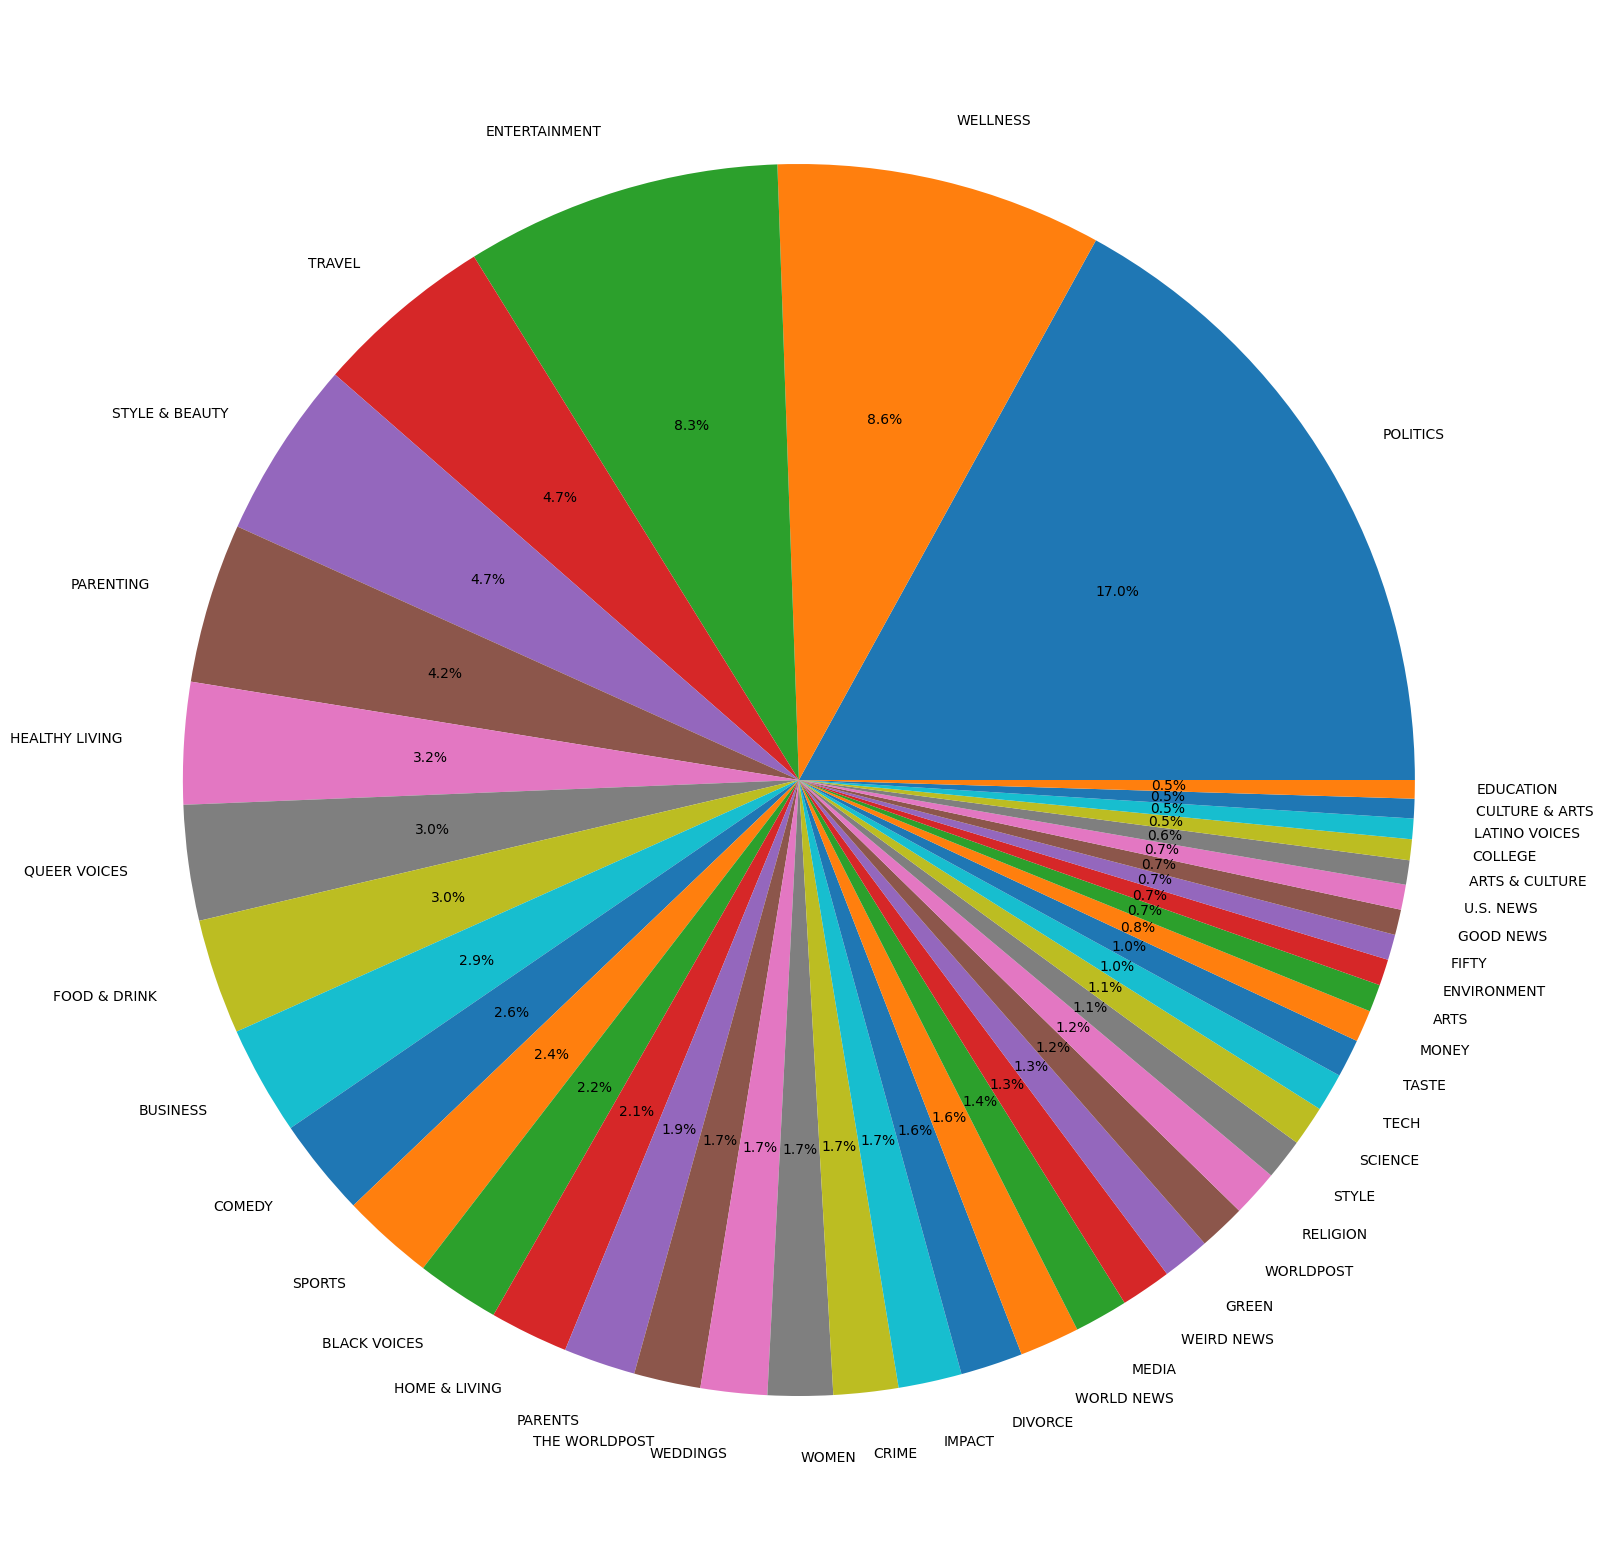

In [6]:
fig = plt.figure(figsize=(20,20))
plt.pie(dataset['category'].value_counts().values, 
        labels=dataset['category'].value_counts().index,
        autopct='%1.1f%%');

## Group the Categories

Let's try to group these categories and try to balance the dataset at the same time

In [7]:
categories = dataset['category'].value_counts().index

def group(category_list, name):
    for category in categories:
        if category in category_list:
            dataset.loc[dataset['category'] == category, 'category'] = name

In [8]:
group(["WELLNESS", "HEALTHY LIVING"], name="WELLNESS")
group(["STYLE & BEAUTY", "STYLE"], name="STYLE & BEAUTY")
group(["PARENTING", "PARENTS"], name="PARENTING & PARENTS")
group(["ARTS & CULTURE", "CULTURE & ARTS", "ARTS"], name="ARTS & CULTURE")
group(["THE WORLDPOST", "WORLDPOST", "WORLD NEWS"], name="WORLDNEWS")
group(["ENVIRONMENT", "GREEN"], name="ENVIRONMENT")
group(["FOOD & DRINK", "TASTE"], name="TASTE")

In [9]:
n_classes = dataset['category'].nunique()
print("We have a total of {} categories now".format(n_classes))
dataset['category'].value_counts()

We have a total of 33 categories now


POLITICS               35602
WELLNESS               24639
ENTERTAINMENT          17362
PARENTING & PARENTS    12746
STYLE & BEAUTY         12068
TRAVEL                  9900
WORLDNEWS               9542
TASTE                   8436
QUEER VOICES            6347
BUSINESS                5992
COMEDY                  5400
SPORTS                  5077
BLACK VOICES            4583
HOME & LIVING           4320
ENVIRONMENT             4066
ARTS & CULTURE          3922
WEDDINGS                3653
WOMEN                   3572
CRIME                   3562
IMPACT                  3484
DIVORCE                 3426
MEDIA                   2944
WEIRD NEWS              2777
RELIGION                2577
SCIENCE                 2206
TECH                    2104
MONEY                   1756
FIFTY                   1401
GOOD NEWS               1398
U.S. NEWS               1377
COLLEGE                 1144
LATINO VOICES           1130
EDUCATION               1014
Name: category, dtype: int64

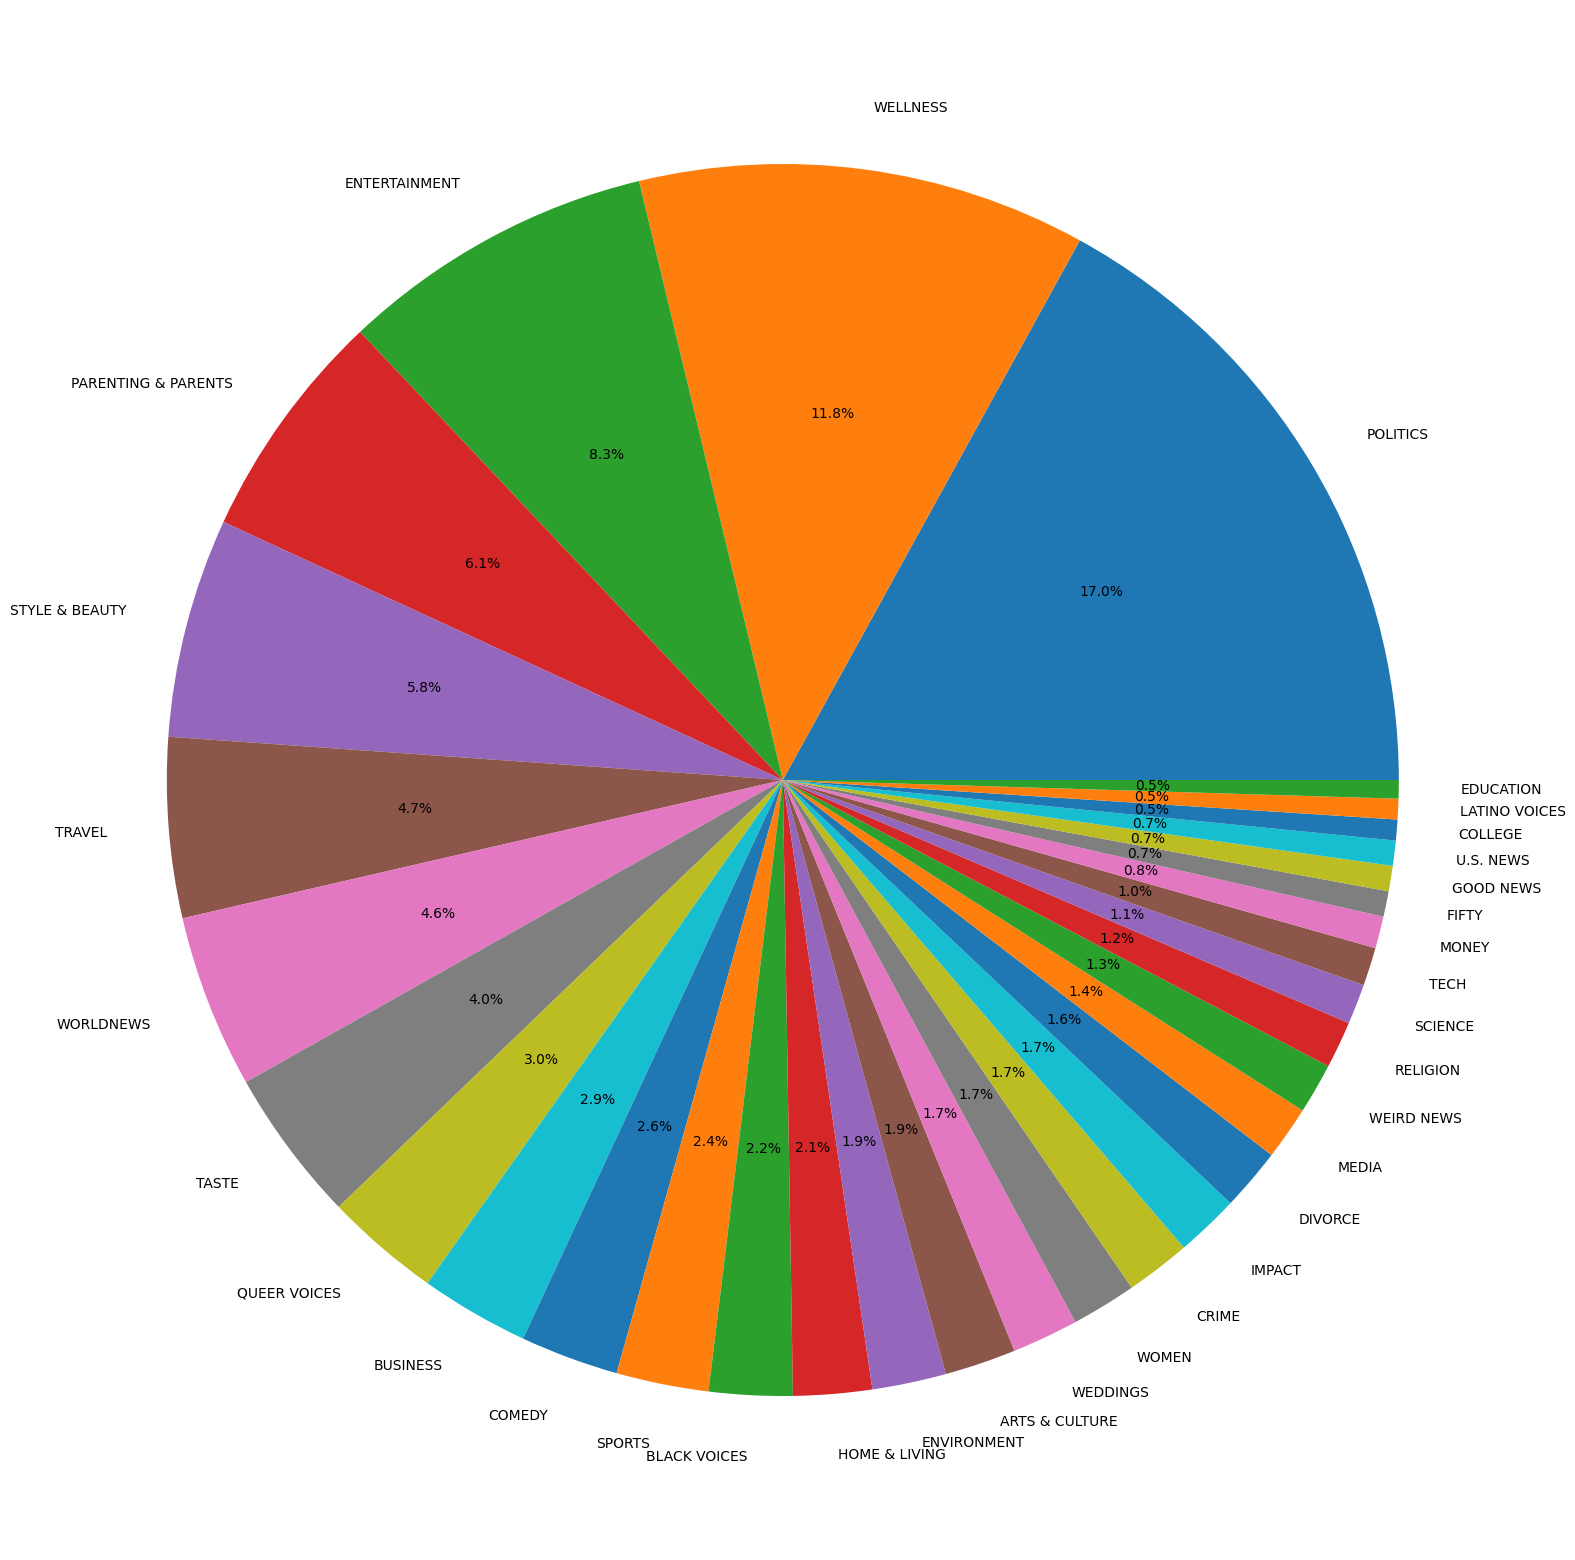

In [10]:
fig = plt.figure(figsize=(20,20))
plt.pie(dataset['category'].value_counts().values, 
        labels=dataset['category'].value_counts().index,
        autopct='%1.1f%%');

## Removing empty values and duplicates

### Duplicate Values

In [11]:
df = dataset.copy()


In [12]:
df.duplicated().sum()

471

In [13]:
df.drop_duplicates(keep='last', inplace=True) 

In [14]:
df.duplicated(subset=['short_description','headline']).sum()

18

In [15]:
df.drop_duplicates(subset=['short_description','headline'],keep='last',inplace=True)

### Empty Values

In [16]:
print(len(df[df['headline'] == ""]))

2


In [17]:
df.loc[df['headline'] == "", 'headline'] = np.nan
df.dropna(subset=['headline'], inplace=True)
print(len(df[df['headline'] == ""]))

0


In [18]:
print(len(df[df['short_description'] == ""]))


19610


## Data Tidying

In [19]:
from sklearn.utils import shuffle
df = shuffle(df, random_state=42)
df.reset_index(inplace=True, drop=True)
df.head()

,headline,category,short_description
0,Science Catches Up to What Authors Have Known Since the Age of Shakespeare: Writing Is Therapeutic,WELLNESS,"Narcissism aside, there may be some very good reasons for people's natural urge to tell their personal stories."
1,"Motherhood Transformed Me, Starting with My Boobs",PARENTING & PARENTS,"The rounded belly I got from pregnancy wasn't that bad -- plus, I expected that. But the watermelons sagging below my relatively small shoulders? Absolutely ridiculous."
2,Puerto Rico To Default On Some Debts,POLITICS,Puerto Rico is suffering from a near decade-long recession with a 45 percent poverty rate and a shrinking tax base due to people leaving the island.
3,13 Effective Ways To Refresh Your Home For Under $10 (PHOTOS),HOME & LIVING,And some of them might not even cost you a penny.
4,Gloria Estefan Pens A Powerful Response To Fidel Castro's Death,LATINO VOICES,"The singer said Cuban exiles weren't celebrating his death, but the demise of his ""destructive ideologies."""


In [20]:
df['desc'] = df['headline'].astype(str)+". "+df['short_description']
df.drop(columns =['headline', 'short_description'], axis=1, inplace=True)
df.astype(str)
df['desc'] = df['desc'].str.replace(' ', ' ')   # remove non-breaking space
df.head()

,category,desc
0,WELLNESS,"Science Catches Up to What Authors Have Known Since the Age of Shakespeare: Writing Is Therapeutic. Narcissism aside, there may be some very good reasons for people's natural urge to tell their personal stories."
1,PARENTING & PARENTS,"Motherhood Transformed Me, Starting with My Boobs. The rounded belly I got from pregnancy wasn't that bad -- plus, I expected that. But the watermelons sagging below my relatively small shoulders? Absolutely ridiculous."
2,POLITICS,Puerto Rico To Default On Some Debts. Puerto Rico is suffering from a near decade-long recession with a 45 percent poverty rate and a shrinking tax base due to people leaving the island.
3,HOME & LIVING,13 Effective Ways To Refresh Your Home For Under $10 (PHOTOS). And some of them might not even cost you a penny.
4,LATINO VOICES,"Gloria Estefan Pens A Powerful Response To Fidel Castro's Death. The singer said Cuban exiles weren't celebrating his death, but the demise of his ""destructive ideologies."""


# Train-validation-test split

In [21]:
X,Y = df['desc'],df['category']

#80% to train , 10% for validation , 10% for testing
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
X_val, X_test , y_val, y_test= train_test_split(X_val, y_val, test_size=0.5, random_state=42)

# Tokenizing

In [22]:
oov_tok = "<OOV>"
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token=oov_tok)
tokenizer.filters += "'’“‘”"
tokenizer.fit_on_texts(X_train)
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
len(tokenizer.word_index)

In [24]:
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)

Text(0, 0.5, 'Number of samples')

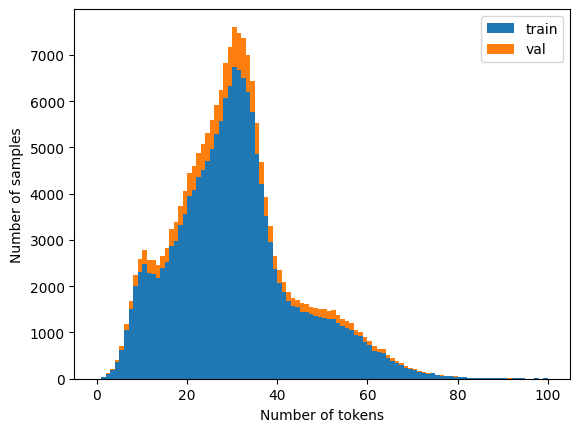

In [25]:
plt.figure()
plt.hist([[len(x) for x in X_train], [len(x) for x in X_val]], range=(0, 100), bins=100, stacked=True, label=['train', 'val'])
plt.legend()
plt.xlabel('Number of tokens')
plt.ylabel('Number of samples')

# Padding

In [26]:
max_length = 80
trunc_type='post'
padding_type='post'
X_train = pad_sequences(X_train, maxlen=max_length, padding=padding_type, truncating=trunc_type)
X_val = pad_sequences(X_val, maxlen=max_length, padding=padding_type, truncating=trunc_type)

X_train.shape, X_val.shape

((167228, 80), (20904, 80), (20904, 80))

# One hot encoding

In [24]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore').fit(np.array(y_train).reshape(-1,1))
with open('one_hot_encoder.pkl', 'wb') as f:
    pickle.dump(enc, f)

In [29]:
y_train = enc.transform(np.array(y_train).reshape(-1,1)).toarray()
y_val = enc.transform(np.array(y_val).reshape(-1,1)).toarray()
y_train.shape, y_val.shape

((167228, 34), (20904, 34), (20904, 34))

# Embedding Matrix for our model

In [30]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip #downloading glove vec word embeddings


In [31]:
# !unzip -q glove.6B.zip #unzipping 

In [32]:
path_to_glove_file = f'{input_path}/glove-global-vectors-for-word-representation/glove.6B.100d.txt'
embedding_dim = 100

In [33]:
#Initialising the embedding matrix with glove vec embeddings

num_tokens = len(tokenizer.word_index.items()) + 2
hits = 0
misses = 0


embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))


# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 68255 words (13409 misses)


# Model Declaration

In [34]:
tf.keras.backend.clear_session()

model = keras.models.Sequential(
    [
        keras.layers.Embedding(
            num_tokens,
            embedding_dim,
            embeddings_initializer=keras.initializers.Constant(embedding_matrix),
            mask_zero=True,
            input_shape=[None],
            trainable=False,
        ),
        keras.layers.Bidirectional(
            keras.layers.LSTM(
                256,
                dropout=0.4,
            )
        ),
        keras.layers.Dense(n_classes, activation="softmax"),
    ]
)

model.summary()


2022-11-20 11:19:24.738409: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-20 11:19:24.738439: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-20 11:19:24.738456: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (shafin-HP-Laptop-14s-fq1786): /proc/driver/nvidia/version does not exist
2022-11-20 11:19:24.738813: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         8166600   
                                                                 
 bidirectional (Bidirectiona  (None, 512)              731136    
 l)                                                              
                                                                 
 dense (Dense)               (None, 34)                17442     
                                                                 
Total params: 8,915,178
Trainable params: 748,578
Non-trainable params: 8,166,600
_________________________________________________________________


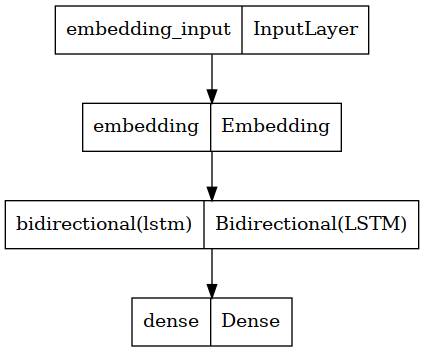

In [35]:
tf.keras.utils.plot_model(model)

# Model training

In [36]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, min_delta=0.0001)

model.compile(
    loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"]
)
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    validation_data=(X_val, y_val),
    epochs=20,
    callbacks=[early_stop, tf.keras.callbacks.TensorBoard("logs")],
)

model.save('trained_model.h5')

In [37]:
fig = plt.figure(figsize=(15,15))

# Plot accuracy
plt.subplot(221)
plt.plot(history.history['accuracy'],'bo-', label = "acc")
plt.plot(history.history['val_accuracy'], 'ro-', label = "val_acc")
plt.title("train_accuracy vs val_accuracy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()

# Plot loss function
plt.subplot(222)
plt.plot(history.history['loss'],'bo-', label = "loss")
plt.plot(history.history['val_loss'], 'ro-', label = "val_loss")
plt.title("train_loss vs val_loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()


# Evaluating and Making Predictions

In [22]:
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import classification_report, confusion_matrix

### Loading tokenizer.pkl

In [23]:
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

### Loading one_hot_encoder.pkl

In [24]:
with open('one_hot_encoder.pkl', 'rb') as f:
    enc = pickle.load(f)

### Loading trained_model.h5

In [25]:
model = keras.models.load_model('trained_model.h5')

2022-11-20 14:01:40.039542: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-20 14:01:40.039569: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-20 14:01:40.039584: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (shafin-HP-Laptop-14s-fq1786): /proc/driver/nvidia/version does not exist
2022-11-20 14:01:40.039844: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
def predict(X):
    X = pad_sequences(tokenizer.texts_to_sequences(X), maxlen=80, padding='post', truncating='post')
    pred = model.predict(X)
    return enc.inverse_transform(pred).flatten()

### Evaluation

                     precision    recall  f1-score   support

     ARTS & CULTURE       0.63      0.53      0.58       410
       BLACK VOICES       0.47      0.37      0.41       435
           BUSINESS       0.58      0.48      0.52       645
            COLLEGE       0.44      0.44      0.44        97
             COMEDY       0.62      0.47      0.53       522
              CRIME       0.60      0.63      0.61       337
            DIVORCE       0.78      0.77      0.77       355
          EDUCATION       0.42      0.51      0.46        99
      ENTERTAINMENT       0.68      0.76      0.72      1708
        ENVIRONMENT       0.56      0.51      0.54       424
              FIFTY       0.55      0.28      0.37       146
          GOOD NEWS       0.58      0.31      0.41       137
      HOME & LIVING       0.76      0.77      0.77       422
             IMPACT       0.50      0.29      0.36       338
      LATINO VOICES       0.56      0.43      0.49       115
              MEDIA    

Text(0.5, 1.0, 'Confusion matrix of model')

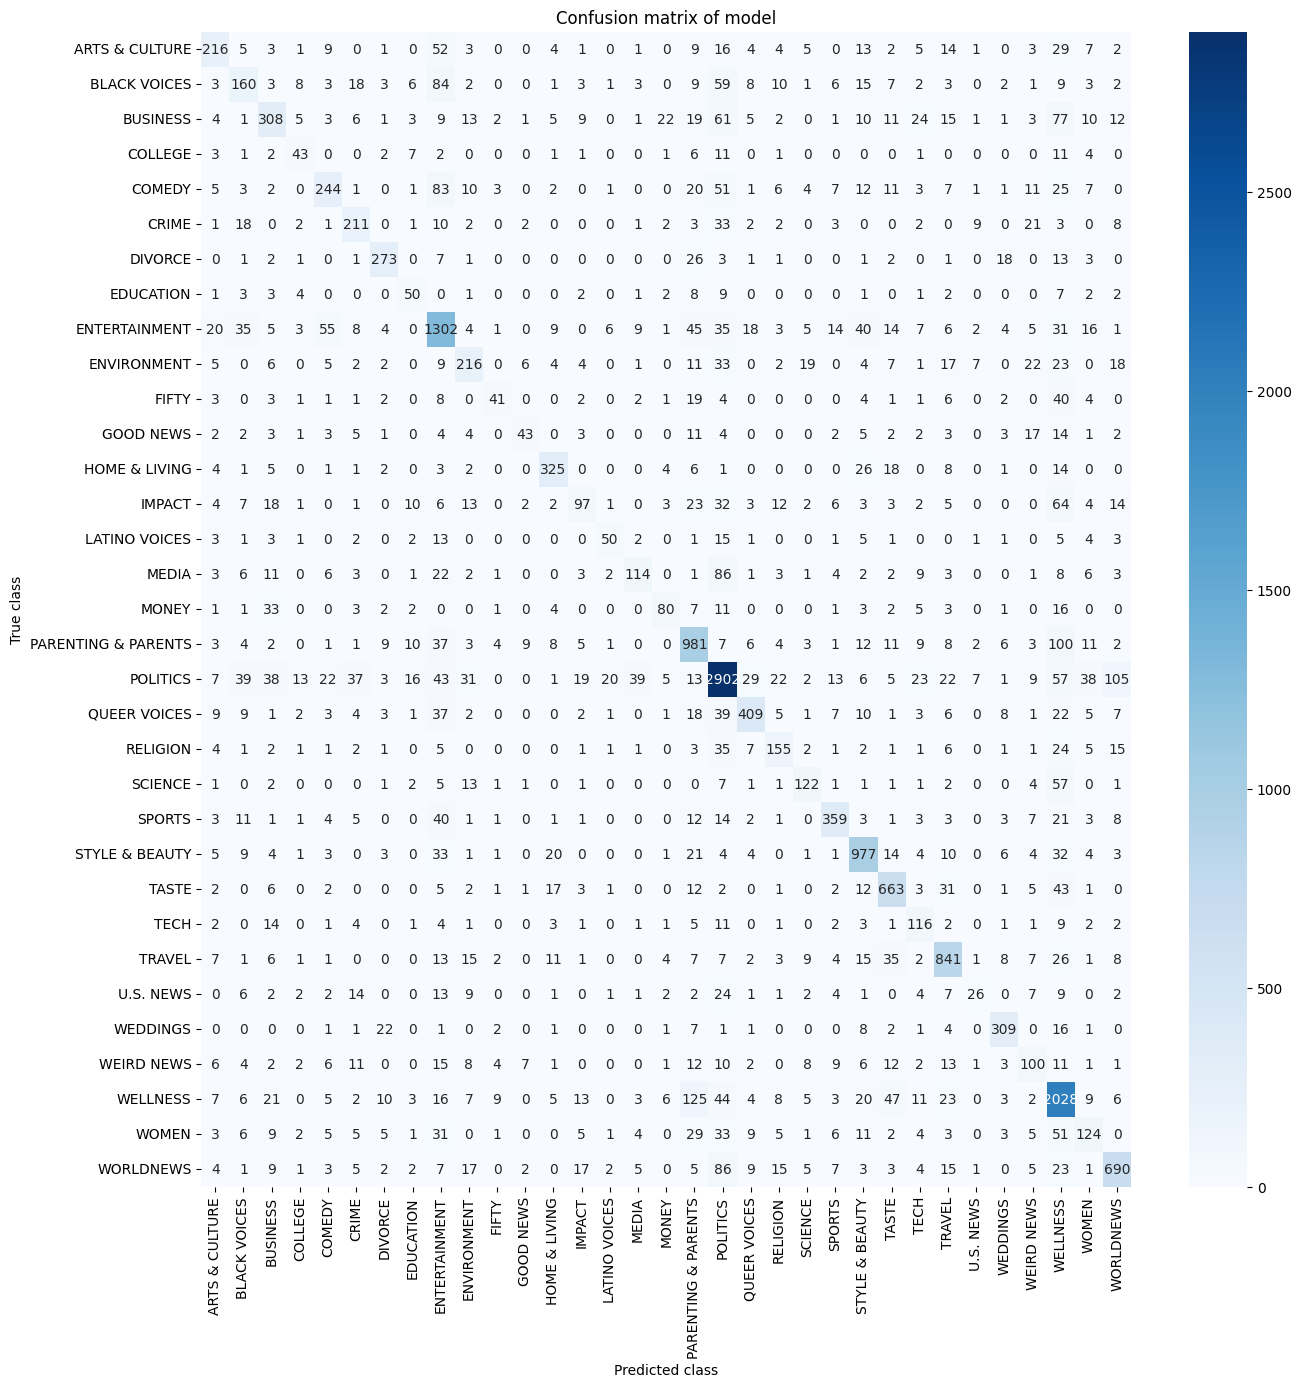

In [33]:
y_pred = predict(X_test)

print(classification_report(y_test, y_pred))
from sklearn.metrics import top_k_accuracy_score
cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(15, 15))
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=enc.categories_[0], yticklabels=enc.categories_[0])
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.title("Confusion matrix of model")


### Prediction

In [28]:
print(
    predict(
        [
            "13 Effective Ways To Refresh Your Home For Under $10 (PHOTOS). And some of them might not even cost you a penny.",
            "Puerto Rico To Default On Some Debts. Puerto Rico is suffering from a near decade-long recession with a 45 percent poverty rate and a shrinking tax base due to people leaving the island.",
            "Science Catches Up to What Authors Have Known Since the Age of Shakespeare: Writing Is Therapeutic. Narcissism aside, there may be some very good reasons for people's natural urge to tell their personal stories.",
        ]
    )
)


1/1 [==============================] - 0s 36ms/step
['HOME & LIVING' 'POLITICS' 'WELLNESS']


# Error analysis

In [42]:
df_test = pd.DataFrame({'text': X_test, 'actual': y_test, 'predicted': y_pred})
df_test

,text,actual,predicted
177645,Daily Meditation: Glory.,RELIGION,RELIGION
195853,"Surrender. ""Know when to hold 'em, Know when to fold 'em"" are lyrics from a famous Kenny Rogers song, and they apply to life in so many ways. When do you give up? When do you throw up your hands and let things take their course, despite being unhappy with the state of it all?",WELLNESS,WELLNESS
107720,Trump Signs GOP Tax Overhaul Into Law. He also approved a short-term spending bill that averts a possible government shutdown.,POLITICS,POLITICS
62418,"Big Picture Parenting. We live in a culture of violence. Despite awareness campaigns, advocacy groups, and information overload, we continue to accept violence as the norm in this country. We don't consider the big picture until it slaps us in the face. Over and over again.",PARENTING & PARENTS,PARENTING & PARENTS
69416,"Jim Carrey Turns Paintbrush On Rudy Giuliani With Ghoulish New Portrait. “Ghouliani: Finally a face we can trust.""",ENTERTAINMENT,ENTERTAINMENT
...,...,...,...
172604,"Adam Lambert Gets the Christian Music Critic Treatment. If audiences only chose entertainment based on Plugged In's reviews over the last couple of years, they would have gone to see The Blind Side and a couple of Pixar movies, with the advisory that cars don't actually talk, since that would be witchcraft.",ENTERTAINMENT,ENTERTAINMENT
10653,"NATO Launches Mission In The Aegean Sea To End Smuggling Of Migrants, Refugees. ""It is important that we now act quickly.""",WORLDNEWS,WORLDNEWS
105719,"Kourtney, Kendall And Kylie REALLY Want You To Know They Love A Bargain. 😁",STYLE & BEAUTY,STYLE & BEAUTY
164548,"How to Shop on Cyber Monday and Not Be a Hot Mess. If you can't be bothered with hitting a mall and you love a great deal, the internet is truly your BFF. I don't do Black Friday, but I do love Cyber Monday.",STYLE & BEAUTY,STYLE & BEAUTY


In [43]:
df_fail = df_test[df_test['actual'] != df_test['predicted']]
df_fail

,text,actual,predicted
137759,"Why You Should Have A Say In Airline Mergers. Every time a company goes through bankruptcy court or gets involved in merger talks, it's disappointing to see who does not",MONEY,BUSINESS
72346,The 'F-Word' We Need To Talk About.,WOMEN,WELLNESS
176138,"A Field Guide To The Impossible-To-Dress Pregnant Body. The recent fascination with Kim Kardashian’s maternity wardrobe, and the media's general fixation on pre- and post-baby bodies",PARENTING & PARENTS,STYLE & BEAUTY
6579,"This Week in World War I, April 25-May 1, 1915. The naval attack in February had alerted Ottoman forces to Allied plans. By the time Allied troops began to land on April 25, Ottoman preparations were complete: Extensive fortifications had been built and the defending forces had been increased six-fold.",POLITICS,WORLDNEWS
132699,"Dave Dave, Las Vegas Artist Whose Father Set Him On Fire When He Was A Boy, Dead At 42. Dave was 6 years old when his father gave him a sleeping pill, doused his bed with kerosene and lit it.",U.S. NEWS,PARENTING & PARENTS
...,...,...,...
97897,Of Course There Are Champange Drones In California.,TRAVEL,POLITICS
197322,"Howard Solomon, Artist, Built A Castle In Florida Complete With A Moat And Dungeon (VIDEO). The best part is, you can actually visit the castle and stay overnight in the Blue Moon Room, located in the East tower. Watch",HOME & LIVING,TRAVEL
15413,"Trump Taj Mahal To Close Amid Worker Strike. The casino, once owned by Donald Trump, is the latest casualty in the financially struggling area.",BUSINESS,POLITICS
6525,"University Of Texas Dean To Leave State, Citing Concerns Over New Campus Carry Law. ""How do you criticize someone when you know or suspect that they have a firearm?""",POLITICS,COLLEGE


Text(0.5, 1.0, 'Confusion matrix of failed test samples')

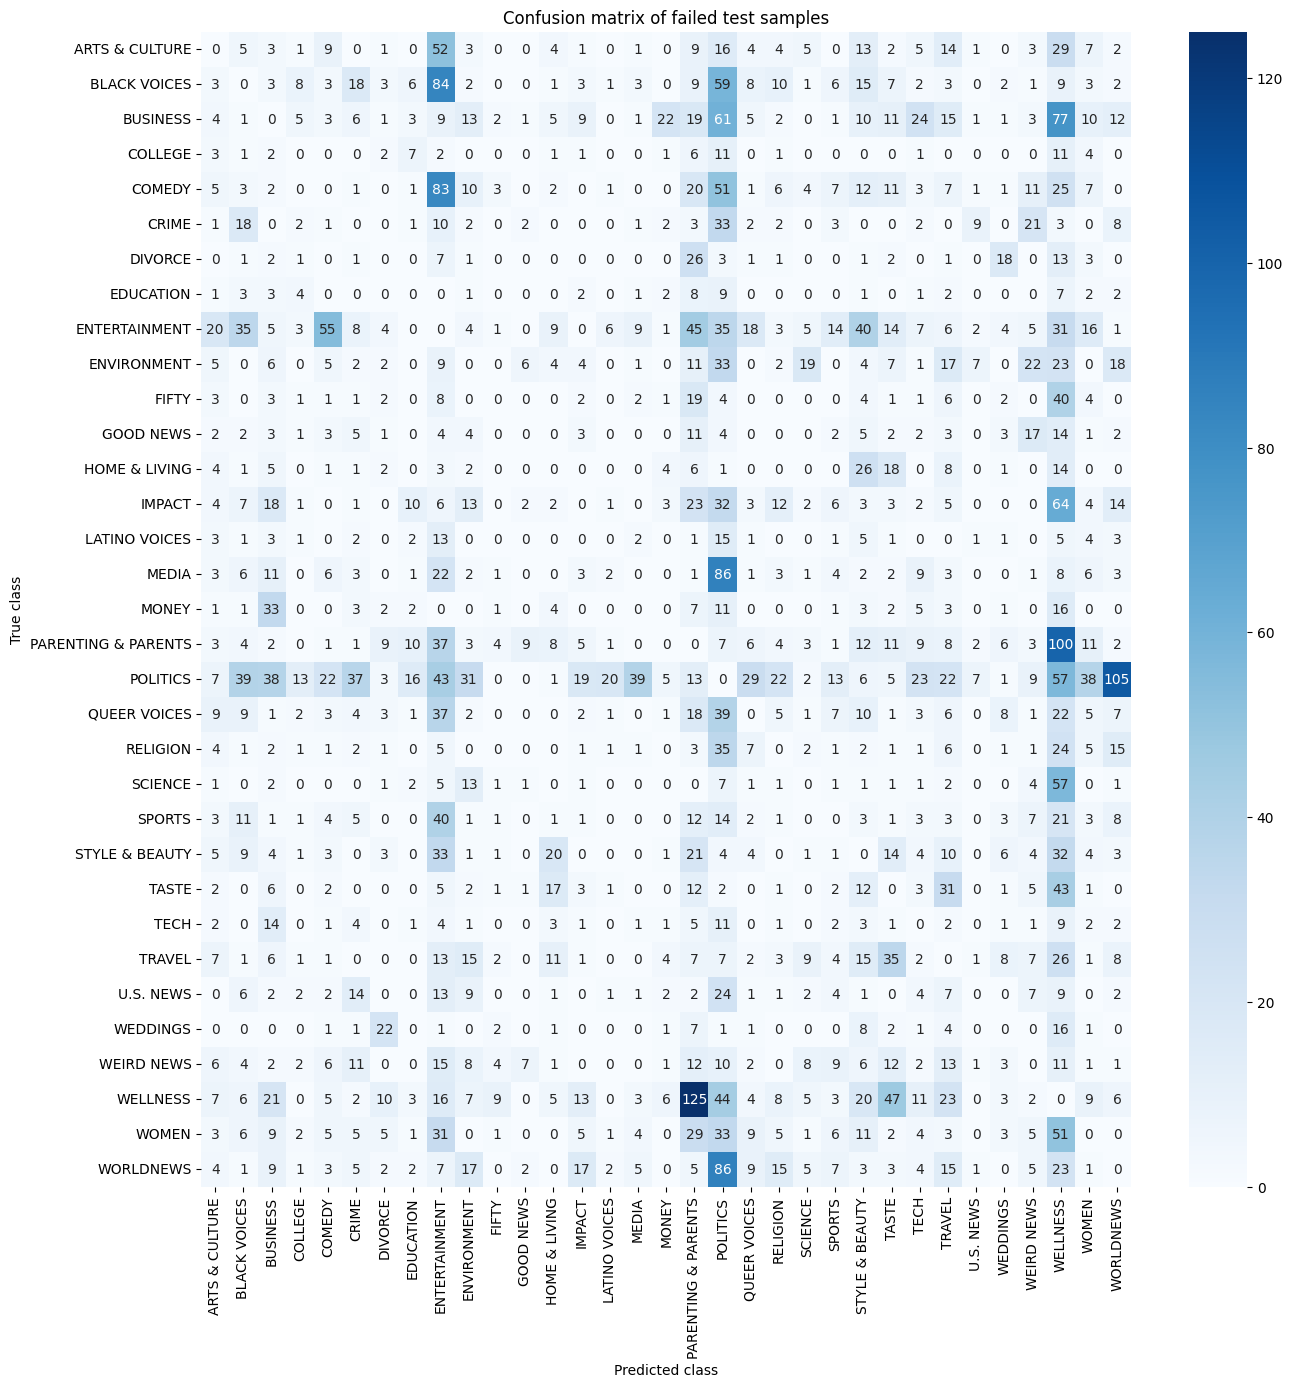

In [46]:
fail_cf_matrix = confusion_matrix(df_fail['actual'], df_fail['predicted'])
plt.figure(figsize=(15, 15))
sns.heatmap(fail_cf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=enc.categories_[0], yticklabels=enc.categories_[0])
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.title("Confusion matrix of failed test samples")